In [78]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# === 1) OKOLJE in VERJETNOSTI ===
L = 50                            # polovica širine terena
N = 2*L + 1                      # skupno število točk j = 0…N-1 (centirano j-L)
np.random.seed(6) #6
p = np.random.uniform(0.1, 0.9, size=N)  # verjetnosti pomika desno

# === 2) DISKRETNI POTENCIAL V(j) ===
def compute_potential(p):
    """
    Izračuna diskretni potencial V in pripadajoče indekse j_idx.

    Parametri:
    -----------
    p : array_like
        Verjetnosti premika desno, dolžine N = 2*L+1.
    L : int
        Polovična širina terena.

    Vrne:
    ------
    V : ndarray
        Diskretni potencial dolžine N.
    j_idx : ndarray
        Indeksi pozicij, centrirani okrog 0, od -L do +L.
    """
    N = len(p)
    V = np.zeros(N)
    for j in range(1, N):
        V[j] = V[j-1] + np.log((1 - p[j]) / p[j])
    return V

V = compute_potential(p)
j_idx = np.arange(N) - L

# === 3) Simulacija naključne hoje ===
def simulate(trials, T_max):
    positions = np.zeros((trials, T_max+1), dtype=int)
    for trial in range(trials):
        x = L
        for t in range(T_max+1):
            positions[trial,t] = x
            if t < T_max:
                step = 1 if np.random.rand() < p[x] else -1
                x = np.clip(x+step, 0, N-1)
    return positions

trials = 200
T0 = 5000
positions_full = simulate(trials, T0)



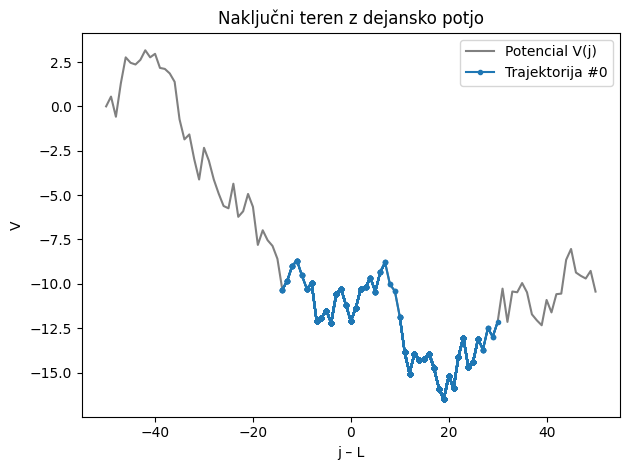

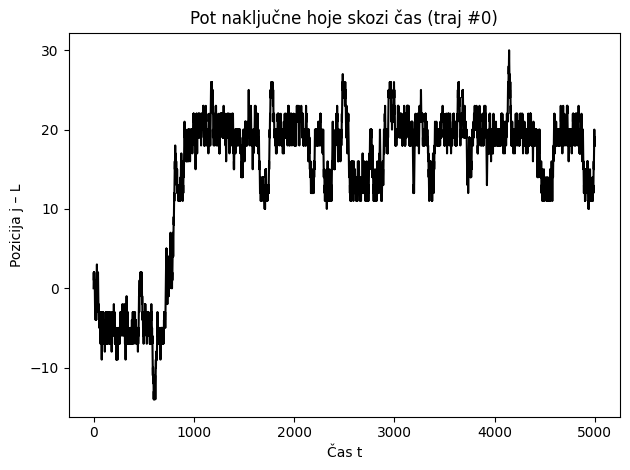

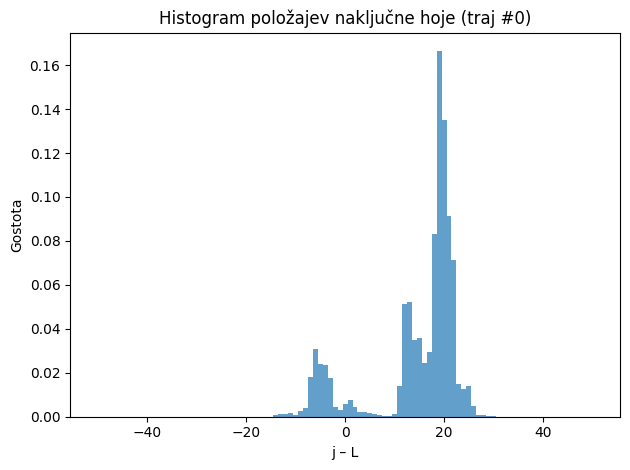

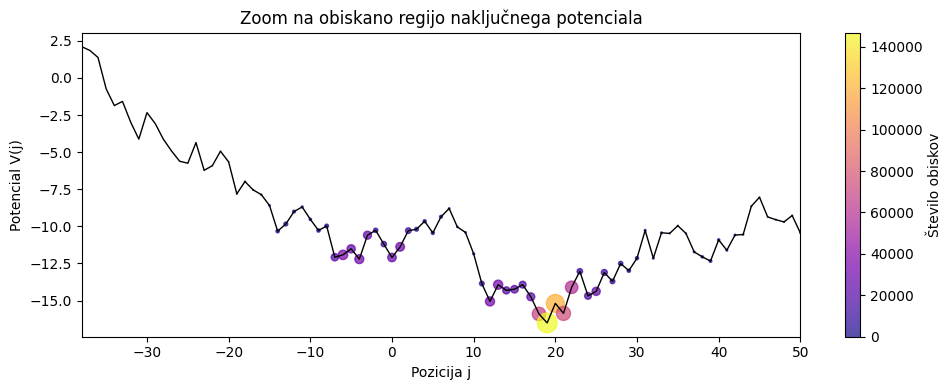

In [79]:
# === 4) Grafik: naključni teren z dejansko potjo (traj #0) ===
plt.figure()
plt.plot(j_idx, V, label='Potencial V(j)', color='gray')
path0 = positions_full[0] - L
plt.plot(path0, V[path0+L], '-o', ms=3, label='Trajektorija #0')
plt.xlabel('j – L')
plt.ylabel('V')
plt.title('Naključni teren z dejansko potjo')
plt.legend(); plt.tight_layout(); plt.show()

# === 5) Grafik: pot naključne hoje skozi čas (traj #0) ===
plt.figure()
plt.plot(np.arange(T0+1), path0, '-k')
plt.xlabel('Čas t')
plt.ylabel('Pozicija j – L')
plt.title('Pot naključne hoje skozi čas (traj #0)')
plt.tight_layout(); plt.show()

# === 6) Grafik: histogram položajev naključne hoje (traj #0) ===
plt.figure()
plt.hist(path0, bins=np.arange(-L-0.5, L+1.5), density=True, alpha=0.7)
plt.xlabel('j – L')
plt.ylabel('Gostota')
plt.title('Histogram položajev naključne hoje (traj #0)')
plt.tight_layout(); plt.show()

# === 8) Grafik: zoom na obiskano regijo potenciala z barvno lestvico ===
# ===  Štetje obiskov po vseh trialih ===
visit_counts = np.zeros(N, dtype=int)
for trial in range(trials):
    for t in range(T0+1):
        visit_counts[positions_full[trial, t]] += 1

# Omejitev na dejansko obiskano področje + margin
visited_positions = np.where(visit_counts > 0)[0]
min_idx = visited_positions.min()
max_idx = visited_positions.max()
margin = 10
start = max(0, min_idx - margin)
end = min(N-1, max_idx + margin)

# === 5) Plot zoomenega potenciala z velikostjo & barvo po številu obiskov ===
plt.figure(figsize=(10, 4))
plt.plot(j_idx[start:end+1], V[start:end+1],
         lw=1, color='black', label='Potencial V(j)')
scatter = plt.scatter(
    j_idx[start:end+1], V[start:end+1],
    c=visit_counts[start:end+1],
    s=(visit_counts[start:end+1] / visit_counts.max()) * 200,
    cmap='plasma', alpha=0.7
)
plt.colorbar(scatter, label='Število obiskov')
plt.xlabel('Pozicija j')
plt.ylabel('Potencial V(j)')
plt.title('Zoom na obiskano regijo naključnega potenciala')
plt.xlim(j_idx[start], j_idx[end])
plt.tight_layout()
plt.show()




L   H       e^H        ⟨τ_sim⟩
10   5.915    3.7e+02    4.9e+02
20   6.693    8.1e+02    5.3e+03
30   8.205    3.7e+03    8.3e+04
40  16.404    1.3e+07    8.3e+02
50  23.736    2.0e+10    4.7e+03


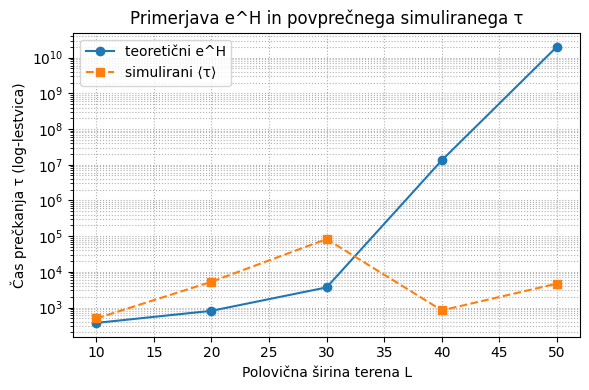

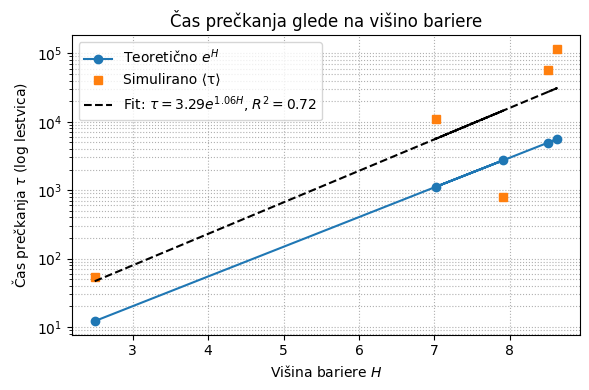

In [80]:

def barrier_height(V):
    min_val = V[0]
    H = 0
    for val in V[1:]:
        H = max(H, val - min_val)
        min_val = min(min_val, val)
    return H

def simulate_hitting_time(p, L, max_steps=int(1e6)):
    x, steps = L, 0
    while 0 < x < 2*L and steps < max_steps:
        x += 1 if np.random.rand() < p[x] else -1
        steps += 1
    return steps

# === MAIN: test za večje L vrednosti ===
L_list = [10, 20, 30, 40, 50]
Hs, tau_th, tau_sim = [], [], []

for L in L_list:
    N = 2*L + 1
    p = np.random.uniform(0.1, 0.9, size=N)        # verjetnost pomika desno
    V = compute_potential(p)                       # izračun disktr. potenciala
    H = barrier_height(V)                          # višina bariere
    
    # povprečje simuliranih časov prečkanja robov [0,2L]
    sims = [simulate_hitting_time(p, L) for _ in range(100)]
    tau_avg = np.mean(sims)
    
    Hs.append(H)
    tau_th.append(np.exp(H))
    tau_sim.append(tau_avg)

# Izpis rezultatov
print("L   H       e^H        ⟨τ_sim⟩")
for L, H, th, sim in zip(L_list, Hs, tau_th, tau_sim):
    print(f"{L:2d}  {H:6.3f}  {th:9.1e}  {sim:9.1e}")

# Po želji: risanje primerjave
plt.figure(figsize=(6,4))
plt.semilogy(L_list, tau_th, 'o-', label='teoretični e^H')
plt.semilogy(L_list, tau_sim, 's--', label='simulirani ⟨τ⟩')
plt.xlabel('Polovična širina terena L')
plt.ylabel('Čas prečkanja τ (log-lestvica)')
plt.title('Primerjava e^H in povprečnega simuliranega τ')
plt.legend()
plt.grid(which='both', linestyle=':')
plt.tight_layout()
plt.show()

# === ČAS PREČKANJA GLEDE BA VIŠINO BARIERE ===
L_list = [10, 20, 30, 40, 50]       
Hs, theoretical, simulated = [], [], []

for L in L_list:
    N = 2*L + 1
    p = np.random.uniform(0.1, 0.9, size=N)
    V = compute_potential(p)
    H = barrier_height(V)
    tau_th = np.exp(H)
    
    # povprečje simuliranih časov prečkanja (100 ponovitev)
    sims = [simulate_hitting_time(p, L) for _ in range(100)]
    tau_sim = np.mean(sims)
    
    Hs.append(H)
    theoretical.append(tau_th)
    simulated.append(tau_sim)

# Prilagoditev: log(τ_sim) = a + b·H
coeffs = np.polyfit(Hs, np.log(simulated), 1)
b, a_log = coeffs
a = np.exp(a_log)
fit_sim = a * np.exp(b * np.array(Hs))
y, y_fit = np.log(simulated), a_log + b * np.array(Hs)
r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2)

# === Risanje ===
plt.figure(figsize=(6,4))
plt.semilogy(Hs, theoretical, 'o-', label='Teoretično $e^H$')
plt.semilogy(Hs, simulated,  's',  label='Simulirano ⟨τ⟩')
plt.semilogy(Hs, fit_sim,      'k--',label=f'Fit: $τ={a:.2f}e^{{{b:.2f}H}}$, $R^2={r2:.2f}$')
plt.xlabel('Višina bariere $H$')
plt.ylabel('Čas prečkanja $τ$ (log lestvica)')
plt.title('Čas prečkanja glede na višino bariere')
plt.legend()
plt.grid(which='both', linestyle=':')
plt.tight_layout()
plt.show()

Prečkalo: 1746/2000, saturiranih: 254


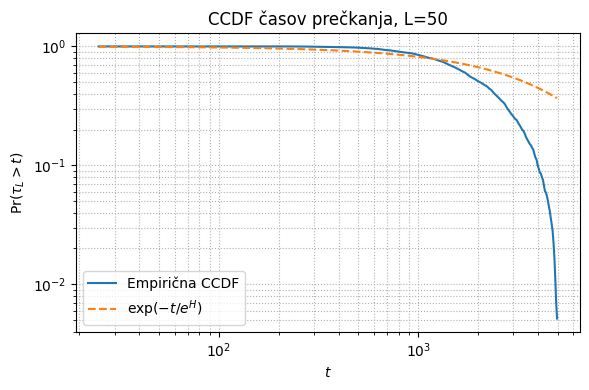

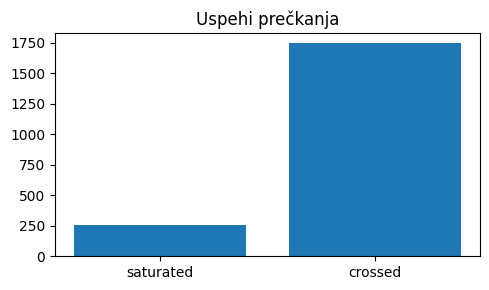

In [96]:
T_max = 5_000  # maksimalno število korakov v simulaciji
TRIALS = 2000   # Število poskusov simulacije

def hitting_time(p, L, T_max):
    x = 0
    for t in range(1, T_max+1):
        # skok levo/desno
        if np.random.rand() < p[x]:
            x += 1
        else:
            x -= 1
        # odbijanje na robu 0
        x = max(0, x)
        if x >= L:
            return t
    return T_max  # saturacija, če ni prečkal v T_max

# 2) Simuliramo τ
taus = np.array([hitting_time(p, L, T_max) for _ in range(TRIALS)])
crossed = taus[taus < T_max]
saturated = np.sum(taus == T_max)
print(f"Prečkalo: {len(crossed)}/{TRIALS}, saturiranih: {saturated}")

# 3) CCDF: Pr(τ > t)
counts, bin_edges = np.histogram(crossed, bins=100, range=(0, T_max))
surv = np.cumsum(counts[::-1])[::-1]      # število τ > t
t_vals = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.figure(figsize=(6,4))
plt.loglog(t_vals, surv/len(crossed), label='Empirična CCDF')
# referenčna eksponentna repa exp(−t/exp(H))
ref = np.exp(-t_vals/np.exp(H))
plt.loglog(t_vals, ref, '--', label=r'$\exp(-t/e^H)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\Pr(\tau_L>t)$')
plt.title(f'CCDF časov prečkanja, L={L}')
plt.legend()
plt.grid(which='both', ls=':')
plt.tight_layout()
plt.show()

# 4) Histogram saturiranih in prečkanih
plt.figure(figsize=(5,3))
plt.bar([0,1], [saturated, len(crossed)], tick_label=['saturated','crossed'])
plt.title('Uspehi prečkanja')
plt.tight_layout()
plt.show()

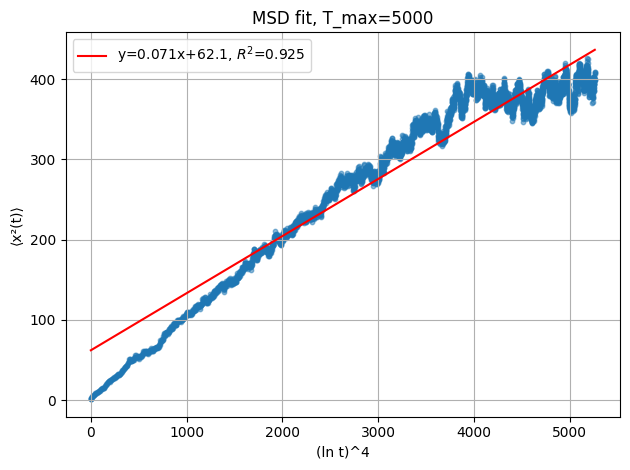

In [81]:
# === 10) Grafik: linearni fit ⟨x²(t)⟩ vs (ln t)^4 ===
def plot_msd(positions, T_max):
    disp = positions - L
    msd = (disp**2).mean(axis=0)
    t = np.arange(1, T_max+1)
    ln4 = np.log(t)**4
    y = msd[1:]
    a,b,r,r_val,_ = stats.linregress(ln4, y)
    plt.figure()
    plt.scatter(ln4, y, s=10, alpha=0.5)
    plt.plot(ln4, a*ln4+b,'r',
             label=f'y={a:.3f}x+{b:.1f}, $R^2$={r**2:.3f}')
    plt.xlabel('(ln t)^4'); plt.ylabel('⟨x²(t)⟩')
    plt.title(f'MSD fit, T_max={T_max}')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plot_msd(positions_full, T0)



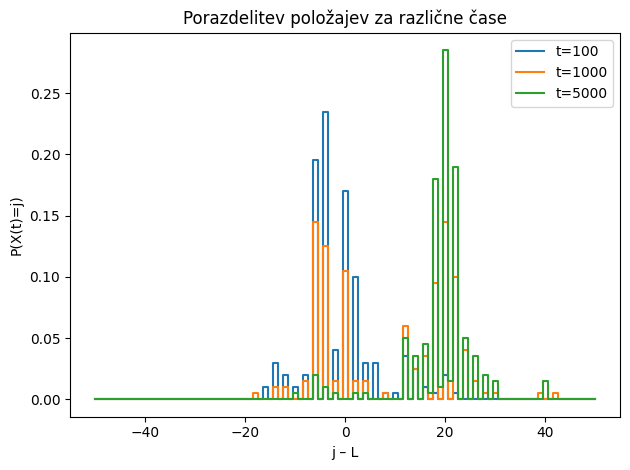

In [82]:
# === 11) Grafik: porazdelitev položajev za različne čase ===
plt.figure()
for t in [100, 1000, 5_000]:
    freq = np.bincount(positions_full[:,t], minlength=N) / trials
    plt.step(j_idx, freq, where='mid', label=f't={t}')
plt.xlabel('j – L'); plt.ylabel('P(X(t)=j)')
plt.title('Porazdelitev položajev za različne čase')
plt.legend(); plt.tight_layout(); plt.show()



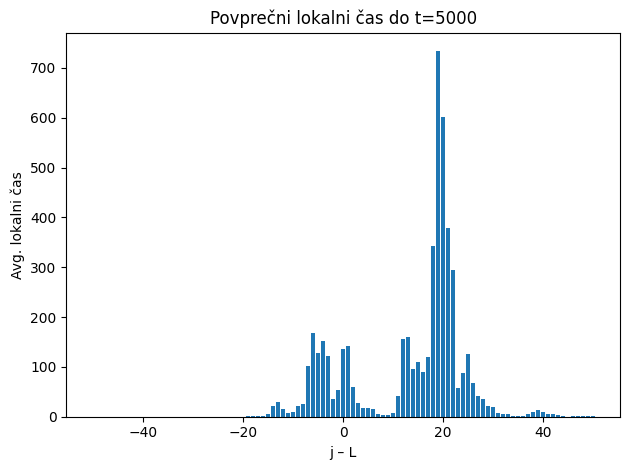

In [83]:
# === 12) Grafik: povprečni lokalni čas do t0 ===
t0 = 5000
local_time = np.zeros(N)
for trial in range(trials):
    # šteje obiske do t0
    local_time += np.bincount(positions_full[trial,:t0], minlength=N)
local_time /= trials
plt.figure()
plt.bar(j_idx, local_time)
plt.xlabel('j – L'); plt.ylabel('Avg. lokalni čas')
plt.title(f'Povprečni lokalni čas do t={t0}')
plt.tight_layout(); plt.show()



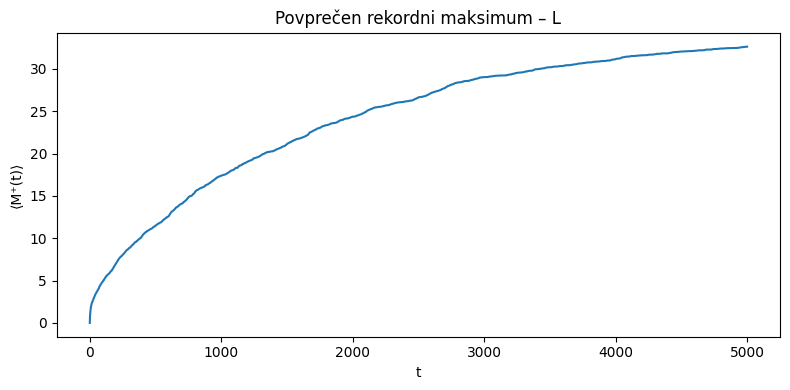

Power-law: ⟨M⁺⟩ ≈ 0.60 · t^0.48
Sinai: ⟨M⁺⟩ ≈ 0.59·(ln t)^2 + -9.70


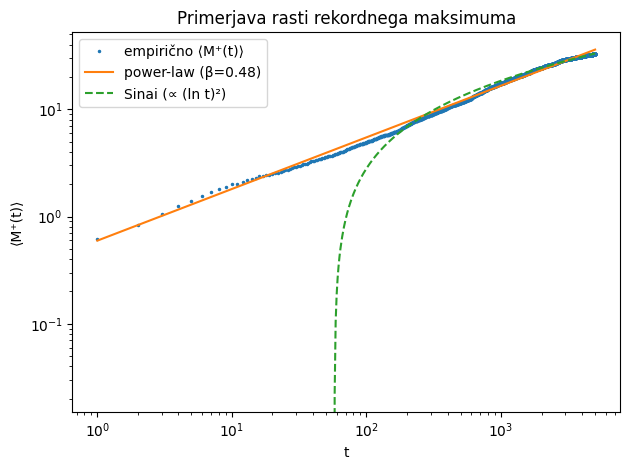

In [84]:
# === Izračun povprečnega rekordnega maksimuma M⁺(t) ===
# Mplus[trial, t] = max_{s≤t} positions[trial, s]
Mplus = np.maximum.accumulate(positions_full, axis=1)
# Odštejemo L, da centriramo okoli 0
meanM = Mplus.mean(axis=0) - L

# === Risanje ===
plt.figure(figsize=(8,4))
plt.plot(np.arange(T0+1), meanM, lw=1.5)
plt.xlabel('t')
plt.ylabel('⟨M⁺(t)⟩')
plt.title('Povprečen rekordni maksimum – L')
plt.tight_layout()
plt.show()

# t = 1…T0
t = np.arange(1, T0+1)
y = meanM[1:]  # preskoč t=0

# 1) Power-law fit: y ≈ A * t^β
β, logA = np.polyfit(np.log(t), np.log(y), 1)
A = np.exp(logA)
print(f"Power-law: ⟨M⁺⟩ ≈ {A:.2f} · t^{β:.2f}")

# 2) Sinai-fit: y ≈ C·(ln t)^2 + D
X = np.log(t)**2
C, D = np.polyfit(X, y, 1)
print(f"Sinai: ⟨M⁺⟩ ≈ {C:.2f}·(ln t)^2 + {D:.2f}")

# 3) Narišemo obe priležitvi skupaj z empiričnimi podatki
plt.plot(t, y, '.', ms=3, label='empirično ⟨M⁺(t)⟩')
plt.plot(t, A*t**β, '-', label=f'power-law (β={β:.2f})')
plt.plot(t, C*(np.log(t)**2)+D, '--', label='Sinai (∝ (ln t)²)')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('t'); plt.ylabel('⟨M⁺(t)⟩')
plt.title('Primerjava rasti rekordnega maksimuma')  # Tvoj dodani naslov
plt.legend()
plt.tight_layout()
plt.show()

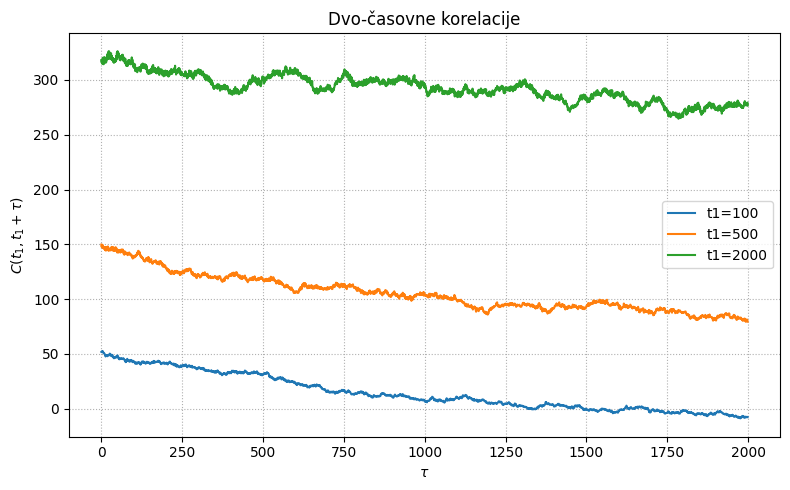

In [85]:
# === 15) Grafik: dvo-časovne korelacije ===
X = positions_full - L        # centrirana spremenljivka
max_tau = 2000

plt.figure(figsize=(8,5))
for t1 in [100, 500, 2000]:
    C = [np.mean(X[:,t1] * X[:,t1+tau]) for tau in range(max_tau)]
    plt.plot(np.arange(max_tau), C, label=f't1={t1}')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$C(t_1,t_1+\tau)$')
plt.title('Dvo-časovne korelacije')
plt.legend()
plt.grid(which='both', ls=':')
plt.tight_layout()
plt.show()